# 1、引言
在实际场景中，很多数据集都是多维度的。随着维度的增加，数据空间的大小（体积）会以指数级别增长，使数据变得稀疏，这便是维度诅咒的难题。维度诅咒不止给异常检测带来了挑战，对距离的计算，聚类都带来了难题。例如基于邻近度的方法是在所有维度使用距离函数来定义局部性，但是，在高维空间中，所有点对的距离几乎都是相等的（距离集中），这使得一些基于距离的方法失效。在高维场景下，一个常用的方法是子空间方法。

集成是子空间思想中常用的方法之一，可以有效提高数据挖掘算法精度。集成方法将多个算法或多个基检测器的输出结合起来。其基本思想是一些算法在某些子集上表现很好，一些算法在其他子集上表现很好，然后集成起来使得输出更加鲁棒。集成方法与基于子空间方法有着天然的相似性，子空间与不同的点集相关，而集成方法使用基检测器来探索不同维度的子集，将这些基学习器集合起来。

下面来介绍两种常见的集成方法：

# 2、Feature Bagging
Feature Bagging，基本思想与bagging相似，只是对象是feature。feature bagging属于集成方法的一种。集成方法的设计有以下两个主要步骤：

1.选择基检测器。这些基本检测器可以彼此完全不同，或不同的参数设置，或使用不同采样的子数据集。Feature bagging常用lof算法为基算法。下图是feature bagging的通用算法：

2.分数标准化和组合方法：不同检测器可能会在不同的尺度上产生分数。例如，平均k近邻检测器会输出原始距离分数，而LOF算法会输出归一化值。另外，尽管一般情况是输出较大的异常值分数，但有些检测器会输出较小的异常值分数。因此，需要将来自各种检测器的分数转换成可以有意义的组合的归一化值。分数标准化之后，还要选择一个组合函数将不同基本检测器的得分进行组合，最常见的选择包括平均和最大化组合函数。

下图是两个feature bagging两个不同的组合分数方法：

(广度优先)
（累积求和）

基探测器的设计及其组合方法都取决于特定集成方法的特定目标。很多时候，我们无法得知数据的原始分布，只能通过部分数据去学习。除此以外，算法本身也可能存在一定问题使得其无法学习到数据完整的信息。这些问题造成的误差通常分为偏差和方差两种。

方差：是指算法输出结果与算法输出期望之间的误差，描述模型的离散程度，数据波动性。

偏差：是指预测值与真实值之间的差距。即使在离群点检测问题中没有可用的基本真值



In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [13]:
# 读取数据
'''
Train_data = pd.read_csv('breast-cancer-unsupervised-ad.csv')
Train_data.loc[Train_data['label']=='o','label']=1
Train_data.loc[Train_data['label']=='n','label']=0
Train_data['label'] = Train_data['label'].astype(float)
'''

"\nTrain_data = pd.read_csv('breast-cancer-unsupervised-ad.csv')\nTrain_data.loc[Train_data['label']=='o','label']=1\nTrain_data.loc[Train_data['label']=='n','label']=0\nTrain_data['label'] = Train_data['label'].astype(float)\n"

# 测试集数据
X_train=Train_data.loc[:, Train_data.columns != 'label']
y_train=Train_data['label']

In [22]:
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.iforest import IForest
from pyod.models.hbos import HBOS
from pyod.models.pca import PCA
from pyod.models.lof import LOF
from pyod.models.knn import KNN
from pyod.utils.data import evaluate_print


In [27]:
from pyod.models.feature_bagging import FeatureBagging
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

if __name__ == "__main__":
    contamination = 0.1  # percentage of outliers
    n_train = 200  # number of training points
    n_test = 100  # number of testing points

    # Generate sample data
    X_train, y_train, X_test, y_test = \
        generate_data(n_train=n_train,
                      n_test=n_test,
                      n_features=2,
                      contamination=contamination,
                      random_state=42)


On Training Data:
FeatureBagging ROC:1.0, precision @ rank n:1.0

On Test Data:
FeatureBagging ROC:0.9978, precision @ rank n:0.9


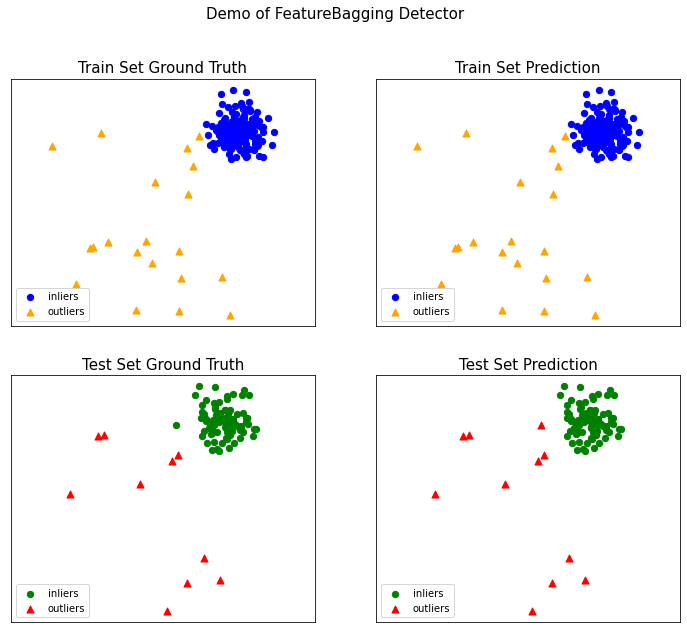

In [29]:
 # train Feature Bagging detector
clf_name = 'FeatureBagging'
clf = FeatureBagging(check_estimator=False)
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# visualize the results
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

# 3、Isolation Forests
孤立森林（Isolation Forest）算法是周志华教授等人于2008年提出的异常检测算法，是机器学习中少见的专门针对异常检测设计的算法之一，方法因为该算法时间效率高，能有效处理高维数据和海量数据，无须标注样本，在工业界应用广泛。

孤立森林属于非参数和无监督的算法，既不需要定义数学模型也不需要训练数据有标签。孤立森林查找孤立点的策略非常高效。假设我们用一个随机超平面来切割数据空间，切一次可以生成两个子空间。然后我们继续用随机超平面来切割每个子空间并循环，直到每个子空间只有一个数据点为止。直观上来讲，那些具有高密度的簇需要被切很多次才会将其分离，而那些低密度的点很快就被单独分配到一个子空间了。孤立森林认为这些很快被孤立的点就是异常点。

用四个样本做简单直观的理解，d是最早被孤立出来的，所以d最有可能是异常。

怎么来切这个数据空间是孤立森林的核心思想。因为切割是随机的，为了结果的可靠性，要用集成（ensemble）的方法来得到一个收敛值，即反复从头开始切，平均每次切的结果。孤立森林由t棵孤立的数组成，每棵树都是一个随机二叉树，也就是说对于树中的每个节点，要么有两个孩子节点，要么一个孩子节点都没有。树的构造方法和随机森林(random forests)中树的构造方法有些类似。流程如下：

     1 从训练数据中随机选择一个样本子集，放入树的根节点；  
     2 随机指定一个属性，随机产生一个切割点V，即属性A的最大值和最小值之间的某个数；  
     3 根据属性A对每个样本分类，把A小于V的样本放在当前节点的左孩子中，大于等于V的样本放在右孩子中，这样就形成了2个子空间  
     4 在孩子节点中递归步骤2和3，不断地构造左孩子和右孩子，直到孩子节点中只有一个数据，或树的高度达到了限定高度。

In [30]:
from pyod.models.iforest import IForest
from pyod.utils.data import generate_data

from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize



On Training Data:
IForest ROC:0.9961, precision @ rank n:0.9

On Test Data:
IForest ROC:1.0, precision @ rank n:1.0


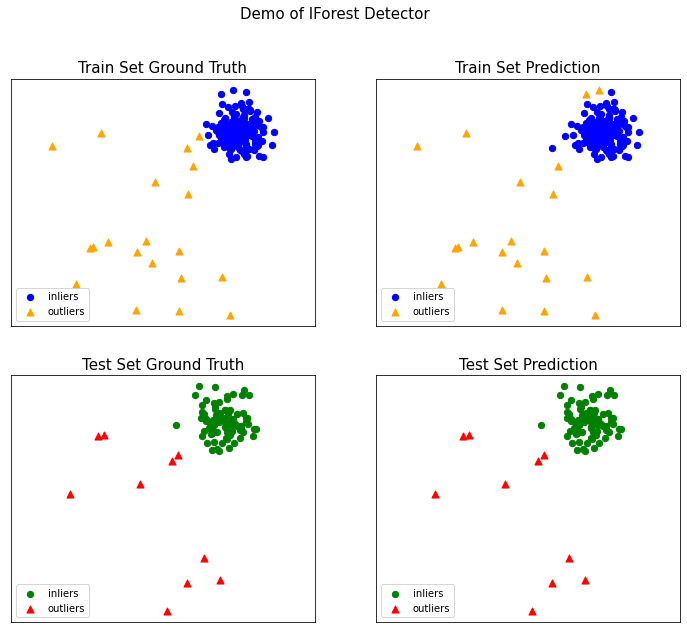

In [31]:
# train IForest detector
clf_name = 'IForest'
clf = IForest()
clf.fit(X_train)

# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# visualize the results
visualize(clf_name, X_train, y_train, X_test, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

In [32]:
# 定义训练检测函数
def train_evaluate(clf_name,clf_model):

    clf_model.fit(X_train) 
    y_train_pred = clf_model.labels_   
    y_train_scores = clf_model.decision_scores_  

    evaluate_print(clf_name, y_train, y_train_scores)

models = {'HBOS':HBOS(),'PCA':PCA(),'LOF':LOF(),'KNN':KNN(),'Feature bagging':FeatureBagging(),'IForest':IForest()}

In [33]:
# 评估训练结果
for item,value in models.items():
    train_evaluate(item,value)

HBOS ROC:0.9947, precision @ rank n:0.8
PCA ROC:0.8964, precision @ rank n:0.8
LOF ROC:0.9997, precision @ rank n:0.95
KNN ROC:0.9992, precision @ rank n:0.95
Feature bagging ROC:0.9992, precision @ rank n:0.95
IForest ROC:0.9958, precision @ rank n:0.9
